Suponga que desea utilizar Programación Genética para encontrar el diseño de un circuito
lógico, tome como, ejemplo el codificador de 7 segmentos. Describa el conjunto de
terminales, el conjunto de funciones y la función de aptitud. Use una librería de Python.

Utilizando la biblioteca DEAP para algoritmos evolutivos, implementando la Programación Genética (GP) encontramos un diseño de circuito lógico que represente un codificador de 7 segmentos.
**Definiciones Claves**


1. **Conjunto de terminales:** Entradas del sistema (bits BCD:𝐴,𝐵,𝐶,𝐷 A,B,C,D) y constantes lógicas (0, 1).
2. **Conjunto de funciones:** Operaciones lógicas básicas como AND, OR, NOT, XOR.
3. **Función de aptitud:** Mide qué tan bien el circuito generado produce las salidas correctas en comparación con la tabla de verdad del codificador de 7 segmentos.





gen	nevals	min	avg  
0  	100   	23 	34.13
1  	65    	23 	30.25
2  	60    	22 	27.08
3  	56    	19 	24.62
4  	51    	17 	22.8 
5  	66    	16 	21.39
6  	78    	15 	19.84
7  	56    	13 	18.49
8  	65    	14 	17.11
9  	54    	13 	15.74
10 	42    	11 	14.63
11 	59    	11 	13.68
12 	64    	9  	12.65
13 	62    	8  	11.64
14 	51    	7  	10.44
15 	62    	6  	9.52 
16 	60    	6  	8.49 
17 	58    	5  	7.53 
18 	68    	5  	6.91 
19 	55    	3  	6.1  
20 	59    	4  	5.77 
21 	62    	3  	5.27 
22 	56    	3  	4.76 
23 	56    	3  	4.48 
24 	51    	3  	4.16 
25 	60    	3  	3.89 
26 	58    	3  	3.55 
27 	53    	2  	3.22 
28 	59    	2  	3.04 
29 	56    	2  	2.87 
30 	51    	1  	2.5  
31 	56    	1  	2.2  
32 	70    	0  	1.97 
33 	55    	0  	1.62 
34 	61    	0  	1.41 
35 	52    	0  	1.11 
36 	60    	0  	0.95 
37 	68    	0  	0.68 
38 	63    	0  	0.25 
39 	68    	0  	0.18 
40 	50    	0  	0.2  
41 	68    	0  	0.19 
42 	61    	0  	0.18 
43 	68    	0  	0.25 
44 	67    	0  	0.17 
45 	65    	0  	0.09 
46 	66    	0 

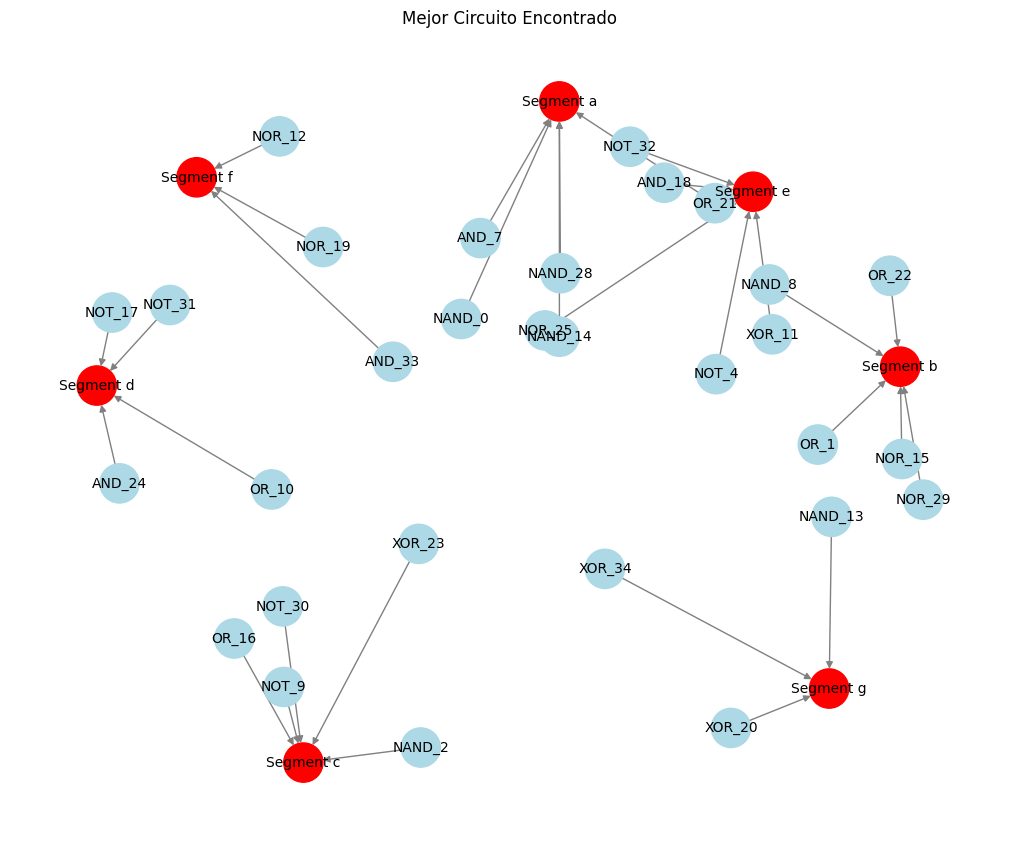

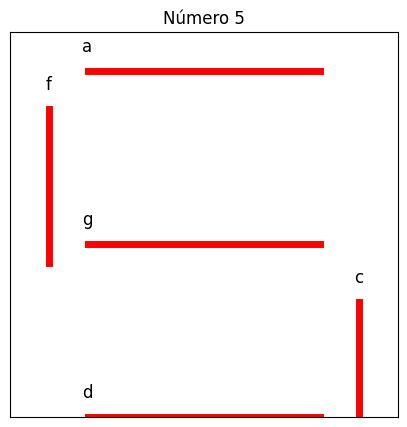

In [62]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from deap import base, creator, tools, algorithms

def AND(a, b): return a & b
def OR(a, b): return a | b
def NOT(a): return ~a & 1
def XOR(a, b): return a ^ b
def NAND(a, b): return ~(a & b) & 1
def NOR(a, b): return ~(a | b) & 1

segmentos_correctos = {
    0: [1, 1, 1, 1, 1, 1, 0],
    1: [0, 1, 1, 0, 0, 0, 0],
    2: [1, 1, 0, 1, 1, 0, 1],
    3: [1, 1, 1, 1, 0, 0, 1],
    4: [0, 1, 1, 0, 0, 1, 1],
    5: [1, 0, 1, 1, 0, 1, 1],
    6: [1, 0, 1, 1, 1, 1, 1],
    7: [1, 1, 1, 0, 0, 0, 0],
    8: [1, 1, 1, 1, 1, 1, 1],
    9: [1, 1, 1, 1, 0, 1, 1],
}

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def eval_individual(individual):
    error = sum(abs(individual[num*7 + i] - seg) for num, seg_correctos in segmentos_correctos.items() for i, seg in enumerate(seg_correctos))
    return (error,)

def mutate(individual):
    idx = random.randint(0, len(individual) - 1)
    individual[idx] = 1 - individual[idx]
    return individual,

IND_SIZE = 10 * 7
POP_SIZE = 100
NGEN = 50
CX_PROB = 0.5
MUT_PROB = 0.2

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

def run_genetic_algorithm():
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    algorithms.eaSimple(pop, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)
    return hof[0]

def plot_circuit_graph(best_individual):
    G = nx.DiGraph()
    logic_gates = ["AND", "OR", "NOT", "XOR", "NAND", "NOR"]
    segment_labels = ["a", "b", "c", "d", "e", "f", "g"]
    segment_nodes = {i: f"Segment {segment_labels[i]}" for i in range(7)}
    for name in segment_nodes.values():
        G.add_node(name, color='red')

    for i in range(0, len(best_individual), 2):
        if best_individual[i] or best_individual[i+1]:
            gate = random.choice(logic_gates)
            gate_node = f"{gate}_{i//2}"
            G.add_node(gate_node, color='lightblue')
            segment_index = (i//2) % 7
            G.add_edge(gate_node, segment_nodes[segment_index])

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42, k=0.5)
    node_colors = [G.nodes[n]['color'] for n in G.nodes]
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=800, font_size=10)
    plt.title("Mejor Circuito Encontrado")
    plt.show()

def plot_result(best_individual):
    fig, ax = plt.subplots(figsize=(5, 5))
    segment_positions = [
        [(0.2, 0.9), (0.8, 0.9)], [(0.9, 0.8), (0.9, 0.4)], [(0.9, 0.3), (0.9, 0.0)],
        [(0.2, 0.0), (0.8, 0.0)], [(0.1, 0.3), (0.1, 0.0)], [(0.1, 0.8), (0.1, 0.4)],
        [(0.2, 0.45), (0.8, 0.45)]
    ]
    segment_labels = ["a", "b", "c", "d", "e", "f", "g"]
    num = random.randint(0, 9)
    segments = best_individual[num*7:(num+1)*7]
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Número {num}")
    for j, segment in enumerate(segments):
        if segment:
            ax.plot(*zip(*segment_positions[j]), linewidth=5, color='red')
            ax.text(segment_positions[j][0][0], segment_positions[j][0][1] + 0.05, segment_labels[j], color='black', fontsize=12, ha='center')
    plt.show()

top_individual = run_genetic_algorithm()
plot_circuit_graph(top_individual)
plot_result(top_individual)